In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import skimage.io as io
from ipywidgets import interact, Text, RadioButtons
import ipywidgets as widgets
from IPython.display import clear_output

from PIL import Image
%matplotlib inline

In [95]:
from pigeon import annotate
from IPython.display import display, Image
#from ipython_display import imshow

class Visualizer:
    def __init__(self, dataframe, pred_path=None, data_path=None, agg='grove', vis_class='planter_skip'):
        self.dataframe = dataframe
        self.data_path = data_path
        self.pred_path = pred_path
        self.vis_class = vis_class
        self.groves = list(dataframe[agg].unique())
        self.agg = agg
    
    def read_imgs(self, row, gray=True):
        read_method = cv2.IMREAD_COLOR
        if gray:
            read_method = cv2.IMREAD_GRAYSCALE
        # img
        if self.data_path:
            img_path = os.path.join(self.data_path, row['ds_part'], 'images', 'rgb', row['name'])
        mask_path = os.path.join(self.data_path,
                                 row['ds_part'],
                                 'labels',
                                 self.vis_class, row['name'].replace(".jpg", ".png"))
        print(mask_path)
        if not os.path.exists(mask_path):
            print(mask_path)
        # prediction_path = os.path.join(experiment_path, 'prediction', row['grove'], row['name'])
        prediction_path = os.path.join(self.pred_path, self.vis_class, row['name'])
       
        if not os.path.exists(prediction_path):
            print(prediction_path)
        if not os.path.exists(img_path):
            print(img_path)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(mask_path, read_method)
        prediction = cv2.imread(prediction_path, read_method)
        # prediction = prediction > 128
        return img, mask, prediction
    

    def visualize_single(self, row):
        img, mask, prediction = self.read_imgs(row, gray=False)
        stacked = np.concatenate([img, mask, prediction], axis=1)
        return stacked

        
    def visualize(self, vis_df, grid_width=2, grid_height=6):
        fig = plt.figure(figsize=(20, 22))
        outer = gridspec.GridSpec(grid_height, grid_width, wspace=0.1, hspace=0.1)

        for i in range(grid_height * grid_width):
            inner = gridspec.GridSpecFromSubplotSpec(1, 3,
                            subplot_spec=outer[i], wspace=0.1, hspace=0.1)
            try:
                row = vis_df.iloc[i]
                for j, (im, cls, label) in enumerate(zip(self.read_imgs(row),
                                                         ['Image', 'Mask', 'Result'],
                                                         ['0', '0', row['name']])):
                    ax = plt.Subplot(fig, inner[j])
                    ax.set_title(cls)
                    if cls == 'Image':
                        #print(im.shape)
                        ax.imshow(im)

                    elif cls == 'Mask':
                        ax.imshow(im, cmap=plt.cm.gray, interpolation='nearest')
                        ax.set_xlabel(str(row['name']))
                    else:
                        ax.imshow(im, cmap='jet', interpolation='nearest')

                    ax.set_xticks([])
                    ax.set_yticks([])
                    fig.add_subplot(ax)
                    
            except Exception as error:
                # print(error)
                continue
        #plt.show()
    
    def visualize_inter(self, min_thresh=0, max_thresh=1, num_samples=18):
#         mean_dice_by_groves = []
#         for gr in set(self.groves):
#             mean_dice_by_groves.append(round(self.dataframe[self.dataframe[self.agg] == gr]['dice'].mean(), 3))

        opt = set(self.groves)
        opt.add(b'all')
        rbtn = RadioButtons(options=opt)
        display(rbtn)
        def on_value_change(change):
            clear_output(True)
#             print('mean_dice')
#             for gr, dc in zip(set(self.groves), mean_dice_by_groves):
#                 print(gr, ':', dc)
            display(rbtn)
            step = num_samples
            show_df = self.dataframe.copy()
            if change['new'] != b'all':
                show_df = show_df[show_df[self.agg] == change['new']]
                
            #show_df = show_df[(show_df['dice'] > min_thresh) & (show_df['dice'] < max_thresh)]
    
            show_df.reset_index(drop=True, inplace=True)          
            parts = int(np.ceil(len(show_df)/step))
            n = len(show_df)
            print('Number of images: {}'.format(n))
            if n < 1:
                print('Nothing to display')
                return None
            def view_image(i):
                start = i*step
                finish = step + i*step
                cur_vis = show_df[start:finish]
                cur_vis.reset_index(drop=True, inplace=True)
                self.visualize(cur_vis)

            interact(view_image, i=(0,parts-1), value=0)
        rbtn.observe(on_value_change, names='value')
    
    def label(self, min_thresh=0, max_thresh=1, num_samples=18):
        show_df = self.dataframe.copy()
        show_df = show_df[(show_df['dice'] > min_thresh) & (show_df['dice'] < max_thresh)]

        show_df.reset_index(drop=True, inplace=True)
        # Create an empty list 
        Row_list =[] 

        # Iterate over show_df row 
        for index, row in show_df.iterrows(): 
            # append the list to the final list 
            Row_list.append(row) 
            
        annotations = annotate(
                  Row_list,
                  options=['good', 'bad'],
                  display_fn=lambda row_x: display(Image.fromarray(self.visualize_single(row_x)))
                )
        return annotations, show_df

In [96]:
full_df = pd.read_csv("/mnt/storage_4tb/ymi/datasets/Agriculture-Vision-2021/supervised/train_val_initial_2020-04-23.csv")
train_df = full_df[full_df["ds_part"] == 'train']
val_df = full_df[full_df["ds_part"] == 'val']

In [97]:
val_df.head(5)

,double_plant,nutrient_deficiency,drydown,storm_damage,waterway,weed_cluster,planter_skip,water,endrow,mask,boundary,combined_mask,id,name,field_id,ds_part,start_x,start_y,end_x,end_y
56944,0.0,38209.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,262144,262144,262144,XBL7ZHEMA_1276-2381-1788-2893,XBL7ZHEMA_1276-2381-1788-2893.jpg,XBL7ZHEMA,val,1276,2381,1788,2893
56945,0.0,0.0,0.0,0.0,17173.0,0.0,0.0,0.0,0.0,262144,219979,219979,RUCCK48L9_13791-5155-14303-5667,RUCCK48L9_13791-5155-14303-5667.jpg,RUCCK48L9,val,13791,5155,14303,5667
56946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36368.0,262144,262144,262144,8N7F8ZDTR_5087-1159-5599-1671,8N7F8ZDTR_5087-1159-5599-1671.jpg,8N7F8ZDTR,val,5087,1159,5599,1671
56947,0.0,0.0,0.0,0.0,0.0,3736.0,0.0,0.0,0.0,262144,262144,262144,DHAT9MTZA_3645-2573-4157-3085,DHAT9MTZA_3645-2573-4157-3085.jpg,DHAT9MTZA,val,3645,2573,4157,3085
56948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31871.0,262144,262144,262144,HFV1KUMI4_908-2921-1420-3433,HFV1KUMI4_908-2921-1420-3433.jpg,HFV1KUMI4,val,908,2921,1420,3433


In [98]:
class_names = ['planter_skip']

# filter this
filtered = []
for cls_name in class_names:
    ds_df = full_df[full_df[cls_name] > 0]
    filtered.append(ds_df)

dataset_df = pd.concat(filtered)
dataset_df.reset_index(drop=True, inplace=True)

In [99]:
dataset_df['ds_part'][0]

'train'

In [100]:
dataset_df

,double_plant,nutrient_deficiency,drydown,storm_damage,waterway,weed_cluster,planter_skip,water,endrow,mask,boundary,combined_mask,id,name,field_id,ds_part,start_x,start_y,end_x,end_y
0,0.0,0.0,0.0,0.0,0.0,0.0,84923.0,0.0,0.0,262144,262144,262144,D6DRCDTHB_8071-5511-8583-6023,D6DRCDTHB_8071-5511-8583-6023.jpg,D6DRCDTHB,train,8071,5511,8583,6023
1,0.0,13714.0,0.0,0.0,0.0,0.0,540.0,0.0,0.0,262144,262144,262144,XT41Q8F7B_3276-1718-3788-2230,XT41Q8F7B_3276-1718-3788-2230.jpg,XT41Q8F7B,train,3276,1718,3788,2230
2,0.0,0.0,0.0,0.0,0.0,0.0,3544.0,0.0,0.0,251186,202270,197991,TD62ZP6DW_4322-5064-4834-5576,TD62ZP6DW_4322-5064-4834-5576.jpg,TD62ZP6DW,train,4322,5064,4834,5576
3,7370.0,0.0,0.0,0.0,0.0,0.0,3872.0,0.0,0.0,262144,262144,262144,PBFW9CDEN_9363-776-9875-1288,PBFW9CDEN_9363-776-9875-1288.jpg,PBFW9CDEN,train,9363,776,9875,1288
4,0.0,0.0,0.0,0.0,0.0,0.0,2797.0,0.0,0.0,262144,76539,76539,WZAD6ITCR_2113-530-2625-1042,WZAD6ITCR_2113-530-2625-1042.jpg,WZAD6ITCR,train,2113,530,2625,1042
5,0.0,40692.0,0.0,0.0,0.0,0.0,1740.0,0.0,0.0,262144,250950,250950,ZH9FN6Q73_2198-8578-2710-9090,ZH9FN6Q73_2198-8578-2710-9090.jpg,ZH9FN6Q73,train,2198,8578,2710,9090
6,6992.0,0.0,0.0,0.0,0.0,0.0,6980.0,0.0,54081.0,262144,262144,262144,HQIAQEHIP_10564-7472-11076-7984,HQIAQEHIP_10564-7472-11076-7984.jpg,HQIAQEHIP,train,10564,7472,11076,7984
7,0.0,0.0,0.0,0.0,0.0,0.0,5684.0,0.0,0.0,262144,262144,262144,I7VYIC9GL_6994-8637-7506-9149,I7VYIC9GL_6994-8637-7506-9149.jpg,I7VYIC9GL,train,6994,8637,7506,9149
8,0.0,0.0,0.0,0.0,0.0,0.0,2976.0,0.0,0.0,262144,262144,262144,DWL1ZGARL_3094-7165-3606-7677,DWL1ZGARL_3094-7165-3606-7677.jpg,DWL1ZGARL,train,3094,7165,3606,7677
9,0.0,0.0,0.0,0.0,0.0,0.0,5843.0,0.0,0.0,262144,262144,262144,WLVGAU7C4_3574-1485-4086-1997,WLVGAU7C4_3574-1485-4086-1997.jpg,WLVGAU7C4,train,3574,1485,4086,1997


In [101]:
visualizer = Visualizer(dataframe=dataset_df,
                        data_path="/mnt/storage_4tb/ymi/datasets/Agriculture-Vision-2021/supervised/Agriculture-Vision-2021",
                        vis_class='planter_skip',
                        pred_path="/mnt/storage_4tb/ymi/datasets/Agriculture-Vision-2021/supervised/artifacts/effnetb0_unet_planter_skip_overfit/predictions",
                        agg='ds_part')
visualizer.visualize_inter(num_samples=8)

RadioButtons(index=1, options=(b'all', 'val', 'train'), value='val')

Number of images: 1197


interactive(children=(IntSlider(value=74, description='i', max=149), Output()), _dom_classes=('widget-interact…

In [ ]:
dataset = 'train'
df_for_visualization = full_df[full_df['ds_part'] == dataset]

In [102]:
was = cv2.imread("/mnt/storage_4tb/ymi/datasets/Agriculture-Vision-2021/supervised/Agriculture-Vision-2021/val_0/labels/planter_skip/H3TYMI63U_535-489-1047-1001.png")
now = cv2.imread("/mnt/storage_4tb/ymi/datasets/Agriculture-Vision-2021/supervised/Agriculture-Vision-2021/val/labels/planter_skip/H3TYMI63U_535-489-1047-1001.png")

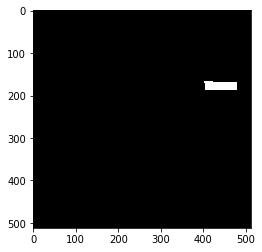

In [105]:
plt.imshow(was)

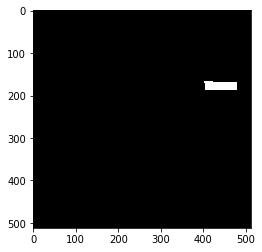

In [106]:
plt.imshow(now)

In [119]:
import shutil
from tqdm import tqdm_notebook
import os
import glob
import shutil
from functools import partial
from multiprocessing.pool import ThreadPool

In [122]:
def copy_and_rename(filepath):
    name = os.path.basename(filepath)
    output_name = os.path.join(output_dir, name.replace(".jpg", ".png"))
    shutil.copy(filepath, output_name)

In [117]:
input_dir = "/mnt/storage_4tb/ymi/datasets/Agriculture-Vision-2021/supervised/artifacts/effnetb0_unet_nutrient_deficiency_overfit/predictions/nutrient_deficiency"
output_dir = "/mnt/storage_4tb/ymi/datasets/Agriculture-Vision-2021/supervised/Agriculture-Vision-2021/train/labels/nutrient_deficiency"
for name in tqdm_notebook(os.listdir(input_dir)):
    name_path = os.path.join(input_dir, name)
    output_name = os.path.join(output_dir, name.replace(".jpg", ".png"))
    shutil.copy(name_path, output_name)

In [120]:
to_copy = glob.glob(os.path.join(input_dir, '*'))

In [121]:
to_copy

['/mnt/storage_4tb/ymi/datasets/Agriculture-Vision-2021/supervised/artifacts/effnetb0_unet_nutrient_deficiency_overfit/predictions/nutrient_deficiency/BL82HKNC4_7861-10274-8373-10786.jpg',
 '/mnt/storage_4tb/ymi/datasets/Agriculture-Vision-2021/supervised/artifacts/effnetb0_unet_nutrient_deficiency_overfit/predictions/nutrient_deficiency/HCW67KPGY_13412-2630-13924-3142.jpg',
 '/mnt/storage_4tb/ymi/datasets/Agriculture-Vision-2021/supervised/artifacts/effnetb0_unet_nutrient_deficiency_overfit/predictions/nutrient_deficiency/GLFK7YZRE_9550-1082-10062-1594.jpg',
 '/mnt/storage_4tb/ymi/datasets/Agriculture-Vision-2021/supervised/artifacts/effnetb0_unet_nutrient_deficiency_overfit/predictions/nutrient_deficiency/ADHEGFT1W_1813-6540-2325-7052.jpg',
 '/mnt/storage_4tb/ymi/datasets/Agriculture-Vision-2021/supervised/artifacts/effnetb0_unet_nutrient_deficiency_overfit/predictions/nutrient_deficiency/QEUMJB2FP_14029-3365-14541-3877.jpg',
 '/mnt/storage_4tb/ymi/datasets/Agriculture-Vision-2021/su

In [136]:


input_dir = "/mnt/storage_4tb/ymi/datasets/Agriculture-Vision-2021/supervised/artifacts/effnetb0_unet_endrow_overfit/predictions/endrow"
output_dir = "/mnt/storage_4tb/ymi/datasets/Agriculture-Vision-2021/supervised/Agriculture-Vision-2021/train/labels/endrow"

# copy_to_mydir will copy any file you give it to DST_DIR
# copy_to_mydir = partial(shutil.copy, dst=DST_DIR))

# list of files we want to copy
to_copy = glob.glob(os.path.join(input_dir, '*'))

with ThreadPool(8) as p:
    p.map(copy_and_rename, to_copy)

In [138]:
check_dir = "/mnt/storage_4tb/ymi/datasets/Agriculture-Vision-2021/supervised/Agriculture-Vision-2021/train/labels/"

for dir_name in os.listdir(check_dir):
    print(dir_name)
    print(len(os.listdir(os.path.join(check_dir, dir_name))))

double_plant
59266
nutrient_deficiency
60827
drydown
62744
storm_damage
57033
waterway
57640
weed_cluster
59778
planter_skip
58141
background
56944
water
57931
endrow
58699
